In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, MobileNetV2
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2
import matplotlib.pyplot as plt


In [2]:
def get_flops(model):
    concrete_func = tf.function(lambda inputs: model(inputs))
    input_shape = [dim if dim is not None else 1 for dim in model.input_shape]
    concrete_func = concrete_func.get_concrete_function(tf.TensorSpec(input_shape, model.inputs[0].dtype))
    
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    with tf.Graph().as_default() as graph:
        tf.graph_util.import_graph_def(graph_def, name='')

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    
    flops = tf.compat.v1.profiler.profile(graph=graph, run_meta=run_meta, cmd='op', options=opts)

    return flops.total_float_ops

In [3]:
def benchmark_models(models):
    model_names = []
    flops_values = []

    for model_name, model in models.items():
        flops = get_flops(model)
        tops = flops / 1e12
        model_names.append(model_name)
        flops_values.append(tops)
        print(f"{model_name} - FLOPs: {flops}, TOPS: {tops}")

    return model_names, flops_values

In [4]:
models = {
    "ResNet50": ResNet50(weights='imagenet'),
    "MobileNetV2": MobileNetV2(weights='imagenet')
}

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 12s 0us/step
14536120/14536120 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [5]:
model_names, flops_values = benchmark_models(models)



Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
ResNet50 - FLOPs: 7755299312, TOPS: 0.007755299312
MobileNetV2 - FLOPs: 615292208, TOPS: 0.000615292208


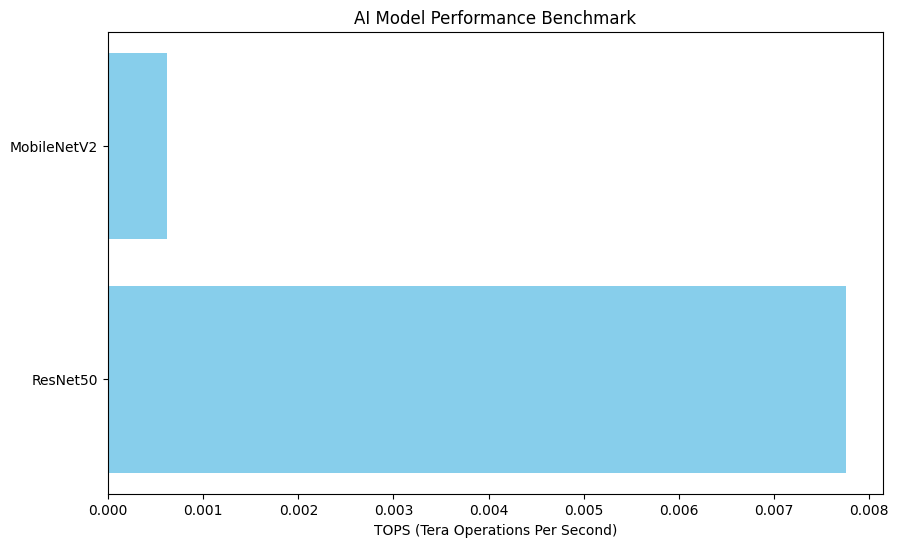

In [6]:
plt.figure(figsize=(10, 6))
plt.barh(model_names, flops_values, color='skyblue')
plt.xlabel('TOPS (Tera Operations Per Second)')
plt.title('AI Model Performance Benchmark')
plt.show()